In [1]:
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential

In [2]:
import pandas as pd
# Read the data and parse the date column into date time format, and set the date column as an index. 
#The data set should originally have 128544 rows, but currently it is 128156 rows, and there are missing values.
df=pd.read_csv(r'C:\\Users\\86130\\00.Project\\03.Datasets\\Regional 15 minutes load data-10-21.csv',
               sep=',',  # Set data delimiter
                     index_col='datatime',  # set index
                     na_values=['?', 0, 'nan'],  # set nan as missing value 
               parse_dates= ['datatime'] )#transfor datatime

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128156 entries, 2018-01-01 00:00:00 to 2021-08-31 23:45:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   total power usage（kw）  128156 non-null  float64
dtypes: float64(1)
memory usage: 2.0 MB


In [4]:
print(df)

                     total power usage（kw）
datatime                                  
2018-01-01 00:00:00            244033.7682
2018-01-01 00:15:00            232720.6402
2018-01-01 00:30:00            231685.6891
2018-01-01 00:45:00            227581.3317
2018-01-01 01:00:00            233482.4269
...                                    ...
2021-08-31 22:45:00            202409.1270
2021-08-31 23:00:00            218576.4635
2021-08-31 23:15:00            200112.5091
2021-08-31 23:30:00            199865.5937
2021-08-31 23:45:00            198483.5592

[128156 rows x 1 columns]


In [5]:
df.describe()

,total power usage（kw）
count,128156.000000
mean,213680.590137
std,45331.197642
min,3294.540900
25%,189740.795300
50%,209407.307500
75%,239193.818575
max,369600.468100


In [6]:
## Check whether there are missing values in the data set, mainly because the date is used as the index, 
#so checking whether the date is missing is a key clue
## Generate a desired date range
expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T')

In [7]:
##find missing dates
missing_dates = expected_dates[~expected_dates.isin(df.index)]

In [8]:
##print missing dates 
print(missing_dates)

DatetimeIndex(['2019-06-14 08:15:00', '2019-06-14 08:30:00',
               '2019-06-14 08:45:00', '2019-06-14 09:00:00',
               '2019-06-14 09:15:00', '2019-06-14 09:30:00',
               '2019-06-14 09:45:00', '2019-06-14 10:00:00',
               '2019-06-14 10:15:00', '2019-06-14 10:30:00',
               ...
               '2021-08-09 05:15:00', '2021-08-09 05:30:00',
               '2021-08-09 05:45:00', '2021-08-09 06:00:00',
               '2021-08-09 06:15:00', '2021-08-09 06:30:00',
               '2021-08-09 06:45:00', '2021-08-09 07:00:00',
               '2021-08-09 07:15:00', '2021-08-09 07:30:00'],
              dtype='datetime64[ns]', length=388, freq=None)


In [9]:
#start_date = '2019-06-13 10:00:00'
#end_date = '2021-08-10 06:15:00'
#filtered_df = df[(df['datatime'] >= start_date) & (df['datatime'] <= end_date)]

## Plotting the data
#plt.figure(figsize=(10, 6))
#plt.plot(filtered_df['datatime'], filtered_df['value'], marker='o', linestyle='-', color='b')
#plt.title('Time Series Plot (2019-06-13 10:00:00 to 2021-08-10 06:15:00)')
#plt.xlabel('Datetime')
#plt.ylabel('Value')
#plt.grid(True)
#plt.show()

In [10]:
missing_data = pd.DataFrame(index=missing_dates, columns=df.columns)# Create a DataFrame with missing dates and NaN values

In [11]:
missing_data

,total power usage（kw）
2019-06-14 08:15:00,NaN
2019-06-14 08:30:00,NaN
2019-06-14 08:45:00,NaN
2019-06-14 09:00:00,NaN
2019-06-14 09:15:00,NaN
...,...
2021-08-09 06:30:00,NaN
2021-08-09 06:45:00,NaN
2021-08-09 07:00:00,NaN
2021-08-09 07:15:00,NaN


In [12]:
missing_data.to_csv(r"C:\Users\86130\00.Project\00.Data Preprocessing\Missing_data_15Minutes.csv",index=True,header=True) 

In [13]:
merged_df = pd.concat([df, missing_data])# Concatenate the missing data with the original DataFrame

In [14]:
# Sort the DataFrame by index (date)
merged_df.sort_index(inplace=True)

In [15]:
merged_df.isnull()

,total power usage（kw）
2018-01-01 00:00:00,False
2018-01-01 00:15:00,False
2018-01-01 00:30:00,False
2018-01-01 00:45:00,False
2018-01-01 01:00:00,False
...,...
2021-08-31 22:45:00,False
2021-08-31 23:00:00,False
2021-08-31 23:15:00,False
2021-08-31 23:30:00,False


In [16]:
import pandas as pd
from sklearn.impute import KNNImputer

In [17]:
###Select features.Only the values of the first 4 moments are used here. 
###Why choose the values of the first 4 moments? Because there are 4 15 minutes in an hour.
features = merged_df.shift(4)

In [18]:
# normalized data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [19]:
# Initialize the KNN model and set the number of neighbors
knn_imputer = KNNImputer(n_neighbors=3)

In [20]:
# Fit KNN model and predict missing values
filled_data = knn_imputer.fit_transform(scaled_features)

In [21]:
# Reverse normalization of filled data
filled_data = scaler.inverse_transform(filled_data)

In [22]:
# Create new dataframe
filled_df = pd.DataFrame(filled_data, columns=features.columns, index=merged_df.index)

In [23]:
# print filled dataset
print(filled_df)

                     total power usage（kw）
2018-01-01 00:00:00          213680.884196
2018-01-01 00:15:00          213680.884196
2018-01-01 00:30:00          213680.884196
2018-01-01 00:45:00          213680.884196
2018-01-01 01:00:00          244033.768200
...                                    ...
2021-08-31 22:45:00          208582.660400
2021-08-31 23:00:00          223853.995300
2021-08-31 23:15:00          205156.643300
2021-08-31 23:30:00          203120.680100
2021-08-31 23:45:00          202409.127000

[128544 rows x 1 columns]


In [24]:
filled_df.to_csv(r"C:\Users\86130\00.Project\00.Data Preprocessing\15mins_filled_df_data_usingknn.csv",index=True,header=True) 

In [25]:
start_date = '2019-06-14 08:15:00'
end_date = '2019-06-15 00:00:00'
date_range_data = filled_df.loc[start_date:end_date]

#Print data within a specific date range
print(date_range_data)

                     total power usage（kw）
2019-06-14 08:15:00          187366.058700
2019-06-14 08:30:00          190750.109100
2019-06-14 08:45:00          195555.541400
2019-06-14 09:00:00           79784.286200
2019-06-14 09:15:00          213680.884196
...                                    ...
2019-06-14 23:00:00          213680.884196
2019-06-14 23:15:00          213680.884196
2019-06-14 23:30:00          213680.884196
2019-06-14 23:45:00          213680.884196
2019-06-15 00:00:00          213680.884196

[64 rows x 1 columns]


In [26]:
start_date1 = '2020-10-20 07:15:00'
end_date1 = '2020-10-20 16:00:00'
date_range_data1 = filled_df.loc[start_date1:end_date1]

#Print data within a specific date range
print(date_range_data1)

                     total power usage（kw）
2020-10-20 07:15:00          190244.176000
2020-10-20 07:30:00          192204.909500
2020-10-20 07:45:00          194930.736300
2020-10-20 08:00:00          208965.396500
2020-10-20 08:15:00          213680.884196
2020-10-20 08:30:00          213680.884196
2020-10-20 08:45:00          213680.884196
2020-10-20 09:00:00          213680.884196
2020-10-20 09:15:00          213680.884196
2020-10-20 09:30:00          213680.884196
2020-10-20 09:45:00          213680.884196
2020-10-20 10:00:00          213680.884196
2020-10-20 10:15:00          213680.884196
2020-10-20 10:30:00          213680.884196
2020-10-20 10:45:00          213680.884196
2020-10-20 11:00:00          213680.884196
2020-10-20 11:15:00          213680.884196
2020-10-20 11:30:00          213680.884196
2020-10-20 11:45:00          213680.884196
2020-10-20 12:00:00          213680.884196
2020-10-20 12:15:00          213680.884196
2020-10-20 12:30:00          213680.884196
2020-10-20 

In [27]:
start_date2 = '2021-01-27 07:00:00'
end_date2 = '2021-01-27 07:00:00'
date_range_data2 = filled_df.loc[start_date2:end_date2]

#Print data within a specific date range
print(date_range_data2)

                     total power usage（kw）
2021-01-27 07:00:00             166443.153


In [34]:
Missdata=pd.read_csv(r'C:\Users\86130\00.Project\03.Datasets\MissDataFilled.csv',index_col='datatime', parse_dates= ['datatime'] )
Missdata.head()

,total power usage（kw）
datatime,
2019-06-14 08:15:00,186429.5893
2019-06-14 08:30:00,186717.2492
2019-06-14 08:45:00,187922.7236
2019-06-14 09:00:00,189876.0669
2019-06-14 09:15:00,188956.6127


In [35]:
data = df
data.head()

,total power usage（kw）
datatime,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [36]:
Merged = pd.concat([data, Missdata])
Merged.head()

,total power usage（kw）
datatime,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [37]:
# summary
summary_stats = Merged.describe()

# To find outliers, you need to check whether there are outliers in the fully populated data set.
outliers = Merged[(Merged - summary_stats.loc['mean']).abs() > 3 * summary_stats.loc['std']]

In [38]:
print(outliers)

                     total power usage（kw）
datatime                                  
2018-01-01 00:00:00                    NaN
2018-01-01 00:15:00                    NaN
2018-01-01 00:30:00                    NaN
2018-01-01 00:45:00                    NaN
2018-01-01 01:00:00                    NaN
...                                    ...
2021-08-09 06:30:00                    NaN
2021-08-09 06:45:00                    NaN
2021-08-09 07:00:00                    NaN
2021-08-09 07:15:00                    NaN
2021-08-09 07:30:00                    NaN

[128544 rows x 1 columns]


In [39]:
outliers.isnull()

,total power usage（kw）
datatime,
2018-01-01 00:00:00,True
2018-01-01 00:15:00,True
2018-01-01 00:30:00,True
2018-01-01 00:45:00,True
2018-01-01 01:00:00,True
...,...
2021-08-09 06:30:00,True
2021-08-09 06:45:00,True
2021-08-09 07:00:00,True


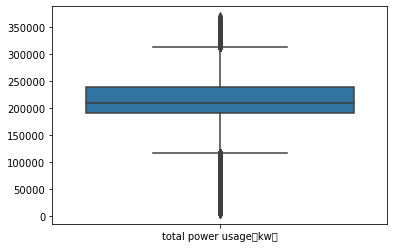

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=Merged)
plt.show()

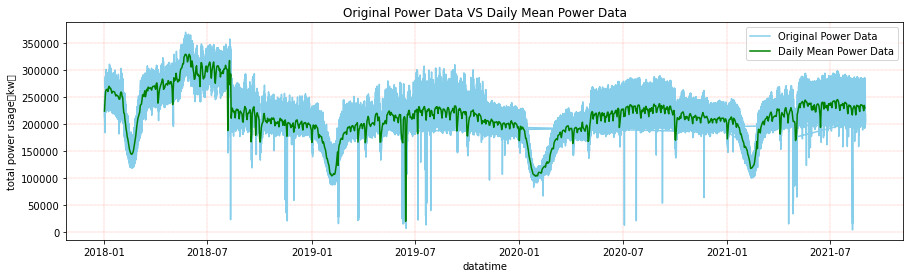

In [41]:
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.plot(Merged,label='Original Power Data',color='skyblue')
plt.plot(Merged.resample('D').mean(),label='Daily Mean Power Data',color='green')
plt.title('Original Power Data VS Daily Mean Power Data')
plt.ylabel('total power usage（kw）')
plt.xlabel('datatime')
plt.legend()###Original data and daily average power curve comparison chart

In [42]:

data_day_mean=Merged.resample('D').mean().values
data_values=[Merged.iloc[i+96*j,0]-data_day_mean[j][0] for j in range(1339) for i in range(96)]

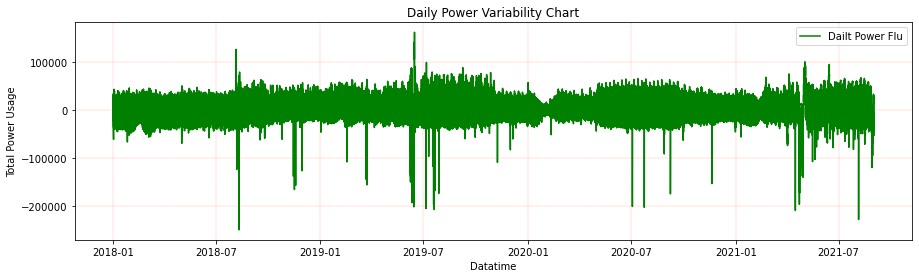

In [43]:
dti=pd.date_range("2018-01-01",periods=128544,freq="15T")
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Daily Power Variability Chart')
plt.ylabel('Total Power Usage')
plt.xlabel('Datatime')
plt.plot(dti,data_values,color='green',label='Dailt Power Flu')
plt.legend()

In [44]:
data_values=pd.Series(data_values)
mean=data_values.mean()
std=data_values.std()
rule=(mean-3*std > data_values) | (mean+3*std < data_values)
rule.sum()

675

In [45]:
data_del_wrong=data_values.copy()
data_del_wrong[rule]=data_values.median()#
data_del_wrong[rule]=pd.Series(data_del_wrong).rolling(10,center=True).mean()[rule]##
data_smooth=pd.Series(data_del_wrong)

In [46]:
data_smooth.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [47]:
data_del_wrong.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [48]:
data_values.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [49]:
Merged.head()

,total power usage（kw）
datatime,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [46]:
Merged.to_csv(r"C:\Users\86130\01.CDS590\Power Load Data Processing\AfterProcessingMerged_15mins.csv",index=True,header=True) 

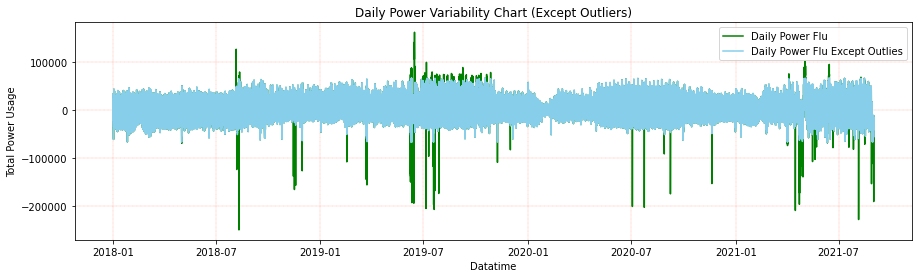

In [47]:
dti=pd.date_range("2018-01-01",periods=128544,freq="15T")
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Daily Power Variability Chart (Except Outliers)')
plt.ylabel('Total Power Usage')
plt.xlabel('Datatime')
plt.plot(dti,data_values,color='green',label='Daily Power Flu')
plt.plot(dti,data_smooth,color='skyblue',label='Daily Power Flu Except Outlies')
plt.legend()

In [48]:
data_smooth.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [49]:
data_smooth=np.asarray(data_smooth)

In [51]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data_smooth.reshape(-1,1))[:,0]
data_scaled

array([0.65339093, 0.56935004, 0.56166179, ..., 0.38329839, 0.38329839,
       0.38329839])

In [58]:
import pickle as pk
with open('scaler.pkl','wb')as file:
    pk.dump(scaler,file)